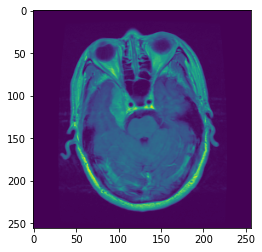

In [1]:
import numpy as np
import nibabel as nb
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
##new
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Activation, Dropout, Flatten, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
img = nb.load("/content/drive/MyDrive/DataO5/image.nii")
load_nii = np.array(img.dataobj)
plt.imshow(load_nii[1])

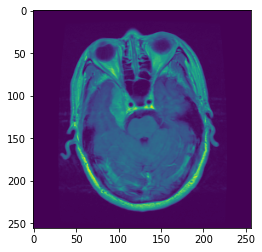

In [2]:
plt.imshow(load_nii[1])

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
load_nii.shape


(3064, 256, 256)

In [5]:
labels =[]
for i in range(708):
  labels.append(0)
for i in range(1426):
  labels.append(1)
for i in range(930):
  labels.append(2)
len(labels)

3064

In [6]:

Data = np.array(load_nii)
labels = np.array(labels)

print(Data.dtype)
print(labels.dtype)

int16
int64


In [7]:
# plt.imshow(Data[1050],cmap='grey')

In [8]:
del load_nii

In [9]:
# from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils

# to calculate accuracy
from sklearn.metrics import accuracy_score

# loading the dataset
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test, y_train, y_test = train_test_split(Data, labels,test_size=0.0001, random_state=344)


# building the input vector from the 28x28 pixels
X_train = X_train.reshape(X_train.shape[0], 256, 256, 1)
# X_test = X_test.reshape(X_test.shape[0], 256, 256, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 3
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)


Shape before one-hot encoding:  (3063,)
Shape after one-hot encoding:  (3063, 3)


In [10]:
X=X_train.copy()
Y=Y_train.copy()

In [11]:
del Data
del labels
len(X),len(Y)

(3063, 3063)

In [12]:
del X_train

In [13]:
def cnn_model(size, num_cnn_layers):
  # building a linear stack of layers with the sequential model
  model = Sequential()
  # convolutional layer
  model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(256,256,1)))
  model.add(MaxPool2D(pool_size=(1,1)))

  model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
  model.add(MaxPool2D(pool_size=(1,1)))

  model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
  model.add(MaxPool2D(pool_size=(1,1)))

# flatten output of conv
  model.add(Flatten())
# hidden layer


#new
  model.add(Dense(50, activation='relu'))
  model.add(Dense(250, activation='relu'))
  model.add(Dropout(0.05))
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.05))

#new end
  model.add(Dense(100, activation='relu'))
#new end
  model.add(Dense(250, activation='relu'))

# output layer
  model.add(Dense(3, activation='softmax'))

# compiling the sequential model
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
  return model


In [14]:
IMAGE_SIZE=(255,255,3)
model = cnn_model(IMAGE_SIZE, 2)

In [15]:


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 25)      250       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 254, 254, 25)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 25)      5650      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 252, 252, 25)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 250, 250, 25)      5650      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 250, 250, 25)     0

In [17]:
Total_Acc=[]
Ev_List=[]
#set early stopping criteria
# pat = 5 #this is the number of epochs with no improvment after which the training will stop
# early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('fas_mnist_1.h5', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=64):
    model = None
    model = cnn_model(IMAGE_SIZE, 2)
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, 
              verbose=1, validation_split=0.1)
    Ev_List=0
    Ev_List= model.evaluate(val_x, val_y)
    Total_Acc.append(Ev_List[1])  
    
    # print("Val Score: ", model.evaluate(val_x, val_y))
    print("Val Score: ",Ev_List)
    return results

In [ ]:
# len(X_train),len(Y_train)

In [18]:
n_folds=5
epochs=40
batch_size=64

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X, Y, test_size=0.05, 
                                               random_state = 350)
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

# https://www.kaggle.com/code/franklemuchahary/basic-cnn-keras-with-cross-validation/notebook

Training on Fold:  1
Epoch 1/40
41/41 [==============================] - 27s 354ms/step - loss: 1.1376 - accuracy: 0.6620 - val_loss: 0.4854 - val_accuracy: 0.7251
Epoch 2/40
41/41 [==============================] - 11s 274ms/step - loss: 0.3393 - accuracy: 0.8476 - val_loss: 0.3634 - val_accuracy: 0.8454
Epoch 3/40
41/41 [==============================] - 11s 277ms/step - loss: 0.1357 - accuracy: 0.9481 - val_loss: 0.3381 - val_accuracy: 0.8729
Epoch 4/40
41/41 [==============================] - 11s 278ms/step - loss: 0.0654 - accuracy: 0.9771 - val_loss: 0.2900 - val_accuracy: 0.9038
Epoch 5/40
41/41 [==============================] - 12s 281ms/step - loss: 0.0387 - accuracy: 0.9893 - val_loss: 0.4003 - val_accuracy: 0.8969
Epoch 6/40
41/41 [==============================] - 12s 283ms/step - loss: 0.0174 - accuracy: 0.9950 - val_loss: 0.4694 - val_accuracy: 0.9072
Epoch 7/40
41/41 [==============================] - 12s 285ms/step - loss: 0.0176 - accuracy: 0.9947 - val_loss: 0.4000 -

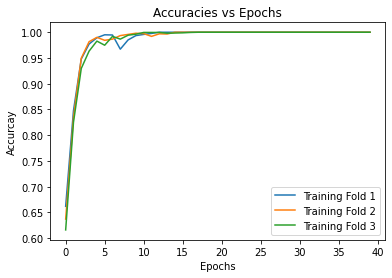

In [19]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')
# plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accurcay')
plt.legend()
plt.show()

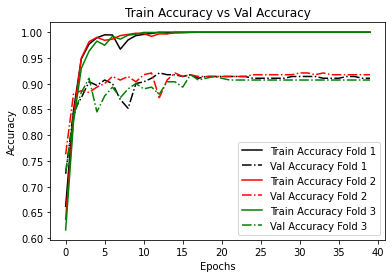

In [20]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
sum(model_history[0].history['accuracy'])

9.26935487985611

In [22]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=model_history[0].history['val_loss'], name="val_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=model_history[0].history['loss'], name="loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=model_history[0].history['val_accuracy'], name="val accuracy"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=model_history[0].history['accuracy'], name="val accuracy"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Loss/Accuracy of Model"
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

fig.show()

In [23]:
#Total Accurcay
# Total_Acc
accurcay=np.array(Total_Acc)
accurcay=accurcay.sum()
accurcay=accurcay/5
print("Total Accurecey is :",accurcay)


Total Accurecey is : 0.9116883158683777


In [24]:
Total_Acc

[0.8831169009208679,
 0.9155844449996948,
 0.9155844449996948,
 0.9220778942108154,
 0.9220778942108154]

In [ ]:
# from sklearn.model_selection import KFold

# n_split=10

# for train_index,test_index in KFold(n_split).split(X):
#   x_train,x_test=X[train_index],X[test_index]
#   y_train,y_test=Y[train_index],Y[test_index]
  
#   # model=create_model()
#   model.fit(x_train, y_train,epochs=5,batch_size=64)
  
#   print('Model evaluation ',model.evaluate(x_test,y_test))

Epoch 1/5
44/44 [==============================] - 746s 17s/step - loss: 1.1628 - accuracy: 0.6275
Epoch 2/5
44/44 [==============================] - 745s 17s/step - loss: 0.3290 - accuracy: 0.8613
Epoch 3/5
44/44 [==============================] - 741s 17s/step - loss: 0.1324 - accuracy: 0.9503
Epoch 4/5
44/44 [==============================] - 734s 17s/step - loss: 0.0629 - accuracy: 0.9797
Epoch 5/5
10/10 [==============================] - 19s 2s/step - loss: 0.2920 - accuracy: 0.9183
Model evaluation  [0.29196980595588684, 0.9183006286621094]
Epoch 1/5
44/44 [==============================] - 749s 17s/step - loss: 0.0564 - accuracy: 0.9851
Epoch 2/5
44/44 [==============================] - 741s 17s/step - loss: 0.0359 - accuracy: 0.9902
Epoch 3/5
44/44 [==============================] - 741s 17s/step - loss: 0.0260 - accuracy: 0.9956
Epoch 4/5
44/44 [==============================] - 730s 17s/step - loss: 0.0359 - accuracy: 0.9920
Epoch 5/5
10/10 [==============================] - 

In [ ]:
# Visualize history
# Plot history: Loss
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

In [ ]:
# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md